In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
print(torch.cuda.is_available())


True


In [17]:
# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Загрузка данных из CSV-файла
df = pd.read_csv('ready_data.csv')  # Замените 'your_dataset.csv' на путь к вашему файлу CSV

# Разделение данных на обучающий и тестовый наборы
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Подготовка текстов и меток
train_texts, train_labels = train_df['text'].tolist(), train_df['category_num'].tolist()
test_texts, test_labels = test_df['text'].tolist(), test_df['category_num'].tolist()


In [19]:
# Инициализация токенизатора и преобразование текста в токены
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Преобразование меток в тензоры
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Перемещение данных на GPU
train_encodings = {key: value.to(device) for key, value in train_encodings.items()}
test_encodings = {key: value.to(device) for key, value in test_encodings.items()}
train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

# Создание DataLoader для обучения и тестирования
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Инициализация модели RoBERTa для классификации на GPU
num_classes = 2  # Замените 2 на количество классов в вашем наборе данных
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
model.to(device)

# Инициализация оптимизатора
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Zubr\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Обучение модели на GPU
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_batches = 0

    for batch_num, batch in enumerate(train_loader, 1):
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Перемещаем данные на GPU
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Считаем общую потерю
        total_loss += loss.item()

        # Считаем количество правильных предсказаний
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == batch[2]).item()

        # Выводим лог каждые, например, 10 батчей
        if batch_num % 10 == 0:
            avg_loss = total_loss / batch_num
            accuracy = correct_predictions / (batch_num * train_loader.batch_size)
            print(f'Epoch {epoch + 1}, Batch {batch_num}/{len(train_loader)}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Выводим лог в конце каждой эпохи
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / (len(train_loader) * train_loader.batch_size)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Проверка точности на тестовом наборе
    model.eval()
    all_preds = []
    with torch.no_grad():
        for test_batch in test_loader:
            test_inputs = {'input_ids': test_batch[0].to(device), 'attention_mask': test_batch[1].to(device)}
            test_outputs = model(**test_inputs)
            test_logits = test_outputs.logits
            test_preds = torch.argmax(test_logits, dim=1)
            all_preds.extend(test_preds.cpu().numpy())

    # Вычисление и вывод точности на тестовом наборе
    test_accuracy = accuracy_score(test_labels.cpu().numpy(), all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1, Loss: 0.6959, Accuracy: 0.4750
Test Accuracy: 0.6000
Epoch 2, Loss: 0.5270, Accuracy: 0.7000
Test Accuracy: 0.8000
Epoch 3, Loss: 0.5107, Accuracy: 0.7250
Test Accuracy: 0.9000
Epoch 4, Loss: 0.4046, Accuracy: 0.8000
Test Accuracy: 0.8000
Epoch 5, Loss: 0.2986, Accuracy: 0.7750
Test Accuracy: 0.8000
Epoch 6, Loss: 0.2181, Accuracy: 0.8500
Test Accuracy: 0.9000
Epoch 7, Loss: 0.1253, Accuracy: 0.8750
Test Accuracy: 0.8000
Epoch 8, Loss: 0.0302, Accuracy: 0.9250
Test Accuracy: 0.8000
Epoch 9, Loss: 0.0812, Accuracy: 0.9000
Test Accuracy: 0.9000
Epoch 10, Loss: 0.0818, Accuracy: 0.8750
Test Accuracy: 0.9000
Epoch 11, Loss: 0.0578, Accuracy: 0.9000
Test Accuracy: 0.8000
Epoch 12, Loss: 0.0459, Accuracy: 0.9250
Test Accuracy: 0.9000
Epoch 13, Loss: 0.0087, Accuracy: 0.9250
Test Accuracy: 0.8000
Epoch 14, Loss: 0.0032, Accuracy: 0.9250
Test Accuracy: 0.8000
Epoch 15, Loss: 0.1147, Accuracy: 0.9000
Test Accuracy: 0.9000


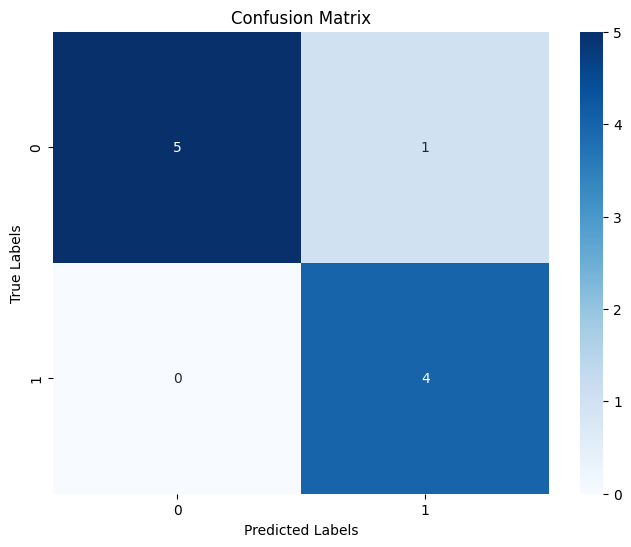

In [23]:
# Вычисление матрицы ошибок
cm = confusion_matrix(test_labels.cpu().numpy(), all_preds)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Сохранение модели
model.save_pretrained('roberta_classification_model')

# Сохранение токенизатора
tokenizer.save_pretrained('roberta_classification_model')

('roberta_classification_model\\tokenizer_config.json',
 'roberta_classification_model\\special_tokens_map.json',
 'roberta_classification_model\\vocab.json',
 'roberta_classification_model\\merges.txt',
 'roberta_classification_model\\added_tokens.json')